In [3]:
import pandas as pd
import numpy as np
import mlflow
from mlflow.tracking import MlflowClient
from xgboost import XGBClassifier
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error
from scipy.stats import ks_2samp, chi2_contingency
import datetime
import matplotlib.pyplot as plt

In [2]:
# Setting up the name of my experiment
mlflow.set_experiment("drift_detection")

2026/01/25 11:43:06 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.schemas
2026/01/25 11:43:06 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.tables
2026/01/25 11:43:06 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.types
2026/01/25 11:43:06 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.constraints
2026/01/25 11:43:06 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.defaults
2026/01/25 11:43:06 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.comments
2026/01/25 11:43:22 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/25 11:43:22 INFO mlflow.store.db.utils: Updating database tables
2026/01/25 11:43:22 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/25 11:43:22 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/25 11:43:24 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/25 11:43:24 INFO alembic.runtime

<Experiment: artifact_location='file:c:/Users/itviv/Documents/GitHub/learning_streamlit/mlruns/2', creation_time=1769321604939, experiment_id='2', last_update_time=1769321604939, lifecycle_stage='active', name='drift_detection', tags={}>

In [10]:
cars_df = pd.read_csv("cars24_data.csv")

In [ ]:
# Randomly Sampling my data to simulate change in data
# This represents current training data
cars_df = cars_df.sample(frac=0.2)

In [13]:
X = cars_df[['km_driven','mileage','age','Petrol','Diesel','Electric']]
y = cars_df[['selling_price']]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
# You might have it in our database or some other storage
# This represents previous training data
prev_df = pd.read_csv("latest_run.csv")

In [14]:
prev_df = cars_df[cars_df['km_driven']> 1000].sample(frac=0.4)

2026/01/25 12:04:38 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet

2026/01/25 12:04:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instea

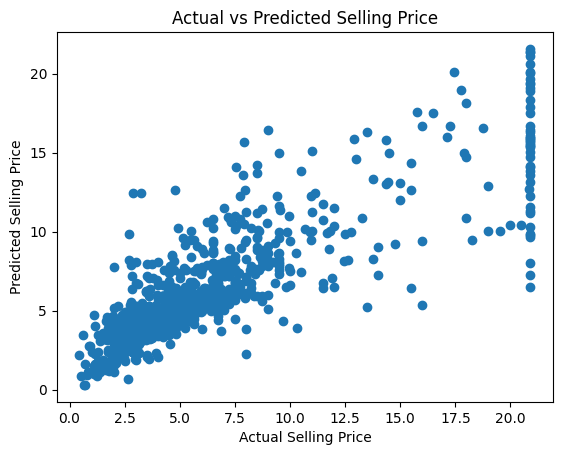

In [15]:
now=datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
with mlflow.start_run(run_name=f"drift_check{now}") as run:

    n_estimators = 200
    learning_rate = 0.05
    max_depth = 4
    xgb_model = XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth
    )
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)

    mape = mean_absolute_percentage_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)

    # log hyperparameters
    mlflow.log_param("max_depth", max_depth)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("n_estimators", n_estimators)
    # used to log model metrics
    mlflow.log_metric("mape", mape)
    mlflow.log_metric("rmse", rmse)
    # tracking data metrics
    mlflow.log_metric("mean of km_driven current set", X_train['km_driven'].mean())
    mlflow.log_metric("mean of age current set", X_train['age'].mean())
    mlflow.log_metric("mean of km_driven previous set", prev_df['km_driven'].mean())
    mlflow.log_metric("mean of age previous set", prev_df['age'].mean())

    plt.figure()
    plt.scatter(y_test, y_pred)
    plt.xlabel("Actual Selling Price")
    plt.ylabel("Predicted Selling Price")
    plt.title("Actual vs Predicted Selling Price")
    plt.savefig("actual_vs_predicted.png")
    mlflow.log_artifact("actual_vs_predicted.png")

    mlflow.sklearn.log_model(xgb_model, "xgb_model")

    ks_features = ['km_driven', 'mileage', 'age']

    for col in ks_features:
        ks_stat, p_value = ks_2samp(
            X_train[col].values,
            prev_df[col].values
        )

        mlflow.log_metric(f"ks_stat_{col}", ks_stat)
        mlflow.log_metric(f"ks_pvalue_{col}", p_value)

    plot_features = ['km_driven', 'mileage', 'age']

    for col in plot_features:
        plt.figure(figsize=(6, 4))

        # Current run distribution
        X_train[col].plot(
            kind='hist',
            bins=30,
            density=True,
            alpha=0.5,
            label='current'
        )
        X_train[col].plot(kind='kde')

        # Previous run distribution
        prev_df[col].plot(
            kind='hist',
            bins=30,
            density=True,
            alpha=0.5,
            label='previous'
        )
        prev_df[col].plot(kind='kde')

        plt.title(f"Distribution drift: {col}")
        plt.xlabel(col)
        plt.ylabel("Density")
        plt.legend()

        file_name = f"drift_hist_kde_{col}.png"
        plt.savefig(file_name, bbox_inches="tight")
        plt.close()

        mlflow.log_artifact(file_name)

    fuel_cols = ['Petrol', 'Diesel', 'Electric']

    X_train['fuel_type'] = X_train[fuel_cols].idxmax(axis=1)
    prev_df['fuel_type'] = prev_df[fuel_cols].idxmax(axis=1)
    
    X_train.to_csv("latest_run.csv", index=False)
    current_counts = X_train['fuel_type'].value_counts()
    prev_counts = prev_df['fuel_type'].value_counts()

    contingency_table = pd.concat(
        [current_counts, prev_counts],
        axis=1,
        keys=['current', 'previous']
    ).fillna(0)

    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

    mlflow.log_metric("chi2_stat_fuel_type", chi2_stat)
    mlflow.log_metric("chi2_pvalue_fuel_type", p_value)